## Regression

In [1]:
# Temporal hack to avoid SSL error
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

/home/repos/venv/trickycases/lib/python3.7/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def train_val_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
    return X_train, X_val, X_test, y_train, y_val, y_test

## Feature engineering

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessing = Pipeline([
    ('std_scaler', StandardScaler()),
])


The StandardScaler in Scikit-Learn standardizes (or normalizes) a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation.



In [6]:
X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)

In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(X_train, y_train)

LinearRegression()

NOTE: Explain fit + predict vs fit_transform

Root Mean Squared Error: 0.7455813830127763
Mean Absolute Error: 0.5332001304956565
R-Squared: 0.575787706032451


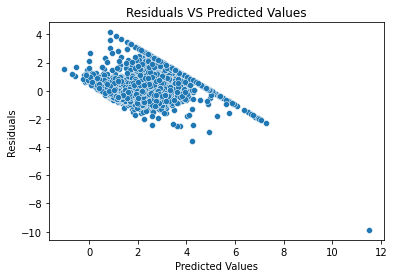

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-Squared: {r2}')

residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals VS Predicted Values')
plt.show()

Here's how it works:

Total sum of squares (SST): This is the sum of the squares of the differences between each actual output and the mean of the output. It represents the total variance in your data.

Residual sum of squares (SSR): This is the sum of the squares of the differences between each actual output and the predicted output by the model. It represents the error of your model.

The R-squared score is then calculated as 1 - (SSR/SST).

There's a bias in this model based on the residuals plot

## Classification

In [25]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

train_df = pd.DataFrame({'text': newsgroups_train.data, 'target': newsgroups_train.target})
test_df = pd.DataFrame({'text': newsgroups_test.data, 'target': newsgroups_test.target})

def create_numerical_features(df):
    df['text_length'] = df['text'].apply(len)
    df['average_word_length'] = df['text'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()))
    df['num_numerical'] = df['text'].apply(lambda x: sum(c.isdigit() for c in x))
    df['num_special'] = df['text'].apply(lambda x: sum(c.isalnum() for c in x))
    return df

train_df = create_numerical_features(train_df)
test_df = create_numerical_features(test_df)

X_train, y_train = train_df.drop('target', axis=1), train_df['target']
X_test, y_test = test_df.drop('target', axis=1), test_df['target']


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

num_cols = ['text_length', 'average_word_length', 'num_numerical', 'num_special']

num_preprocessing = StandardScaler()
text_preprocessing = TfidfVectorizer(stop_words='english')

#alternative_text_preprocessing = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), max_features=20000)

preprocessing = ColumnTransformer(
    transformers=[
        ('num', num_preprocessing, num_cols),
        ('text', text_preprocessing, 'text'),
    ])

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classifier', LogisticRegression()),
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)


/home/repos/venv/trickycases/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


(array([5.260e+03, 1.553e+03, 2.750e+02, 1.200e+02, 6.600e+01, 5.200e+01,
        3.500e+01, 3.400e+01, 2.800e+01, 2.600e+01, 1.600e+01, 1.000e+01,
        1.200e+01, 1.100e+01, 5.000e+00, 5.000e+00, 9.000e+00, 6.000e+00,
        6.000e+00, 3.000e+00]),
 array([7.77418060e-15, 4.84120451e-02, 9.68240903e-02, 1.45236135e-01,
        1.93648181e-01, 2.42060226e-01, 2.90472271e-01, 3.38884316e-01,
        3.87296361e-01, 4.35708406e-01, 4.84120451e-01, 5.32532497e-01,
        5.80944542e-01, 6.29356587e-01, 6.77768632e-01, 7.26180677e-01,
        7.74592722e-01, 8.23004768e-01, 8.71416813e-01, 9.19828858e-01,
        9.68240903e-01]),
 <BarContainer object of 20 artists>)

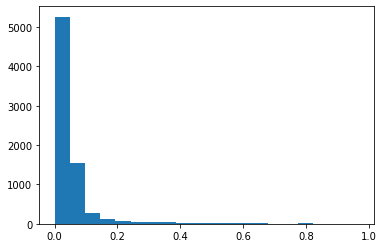

In [27]:
y_proba = pipeline.predict_proba(X_test)

plt.hist(y_proba[:, 1], bins=20)

In [11]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)

print(accuracy)

0.8258098778544876


In [12]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=newsgroups_test.target_names)

print(report)

                          precision    recall  f1-score   support

             alt.atheism       0.80      0.73      0.76       319
           comp.graphics       0.69      0.79      0.74       389
 comp.os.ms-windows.misc       0.75      0.75      0.75       394
comp.sys.ibm.pc.hardware       0.71      0.73      0.72       392
   comp.sys.mac.hardware       0.81      0.83      0.82       385
          comp.windows.x       0.82      0.74      0.78       395
            misc.forsale       0.74      0.87      0.80       390
               rec.autos       0.89      0.90      0.89       396
         rec.motorcycles       0.95      0.95      0.95       398
      rec.sport.baseball       0.88      0.92      0.90       397
        rec.sport.hockey       0.94      0.95      0.95       399
               sci.crypt       0.95      0.91      0.93       396
         sci.electronics       0.76      0.76      0.76       393
                 sci.med       0.88      0.84      0.86       396
         

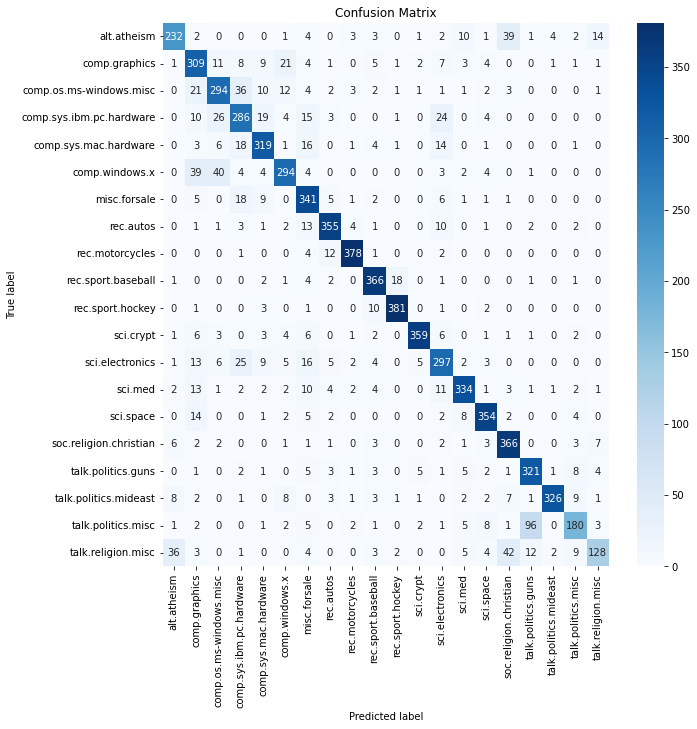

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

class_names = newsgroups_train.target_names  # use actual class names
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [21]:
y_pred

array([ 7,  1,  0, ...,  9, 12, 15])

In [20]:
classifier = pipeline.named_steps['classifier']

preprocessor = pipeline.named_steps['preprocessing']

num_features = list(preprocessor.named_transformers_['num'].get_feature_names_out())
text_features = list(preprocessor.named_transformers_['text'].get_feature_names_out())

features = num_features + text_features

coefficients = classifier.coef_[0]

feature_importances = pd.DataFrame({
    'feature': features,
    'importance': coefficients
})
feature_importances = feature_importances.sort_values(by='importance', key=abs, ascending=False)

feature_importances.head(50)


/home/repos/venv/trickycases/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
72018,keith,4.865164
30073,atheism,4.234254
30077,atheists,3.839703
37418,caltech,3.057163
68488,islamic,3.008639
89435,okcforum,2.817508
68485,islam,2.759925
59521,god,2.713470
79688,mathew,2.681212
69276,jaeger,2.578626


## Classification subproblems (OneVsRestClassifier)

Also known as one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.

In [15]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

classifier = OneVsRestClassifier(LogisticRegression())

preprocessing = ColumnTransformer(
    transformers=[
        ('num', num_preprocessing, num_cols),
        ('text', text_preprocessing, 'text'),
    ])

y_train = label_binarize(newsgroups_train.target, classes=np.arange(20))
y_test = label_binarize(newsgroups_test.target, classes=np.arange(20))

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classifier', OneVsRestClassifier(LogisticRegression())),
])

y_score = pipeline.fit(X_train, y_train).decision_function(X_test)

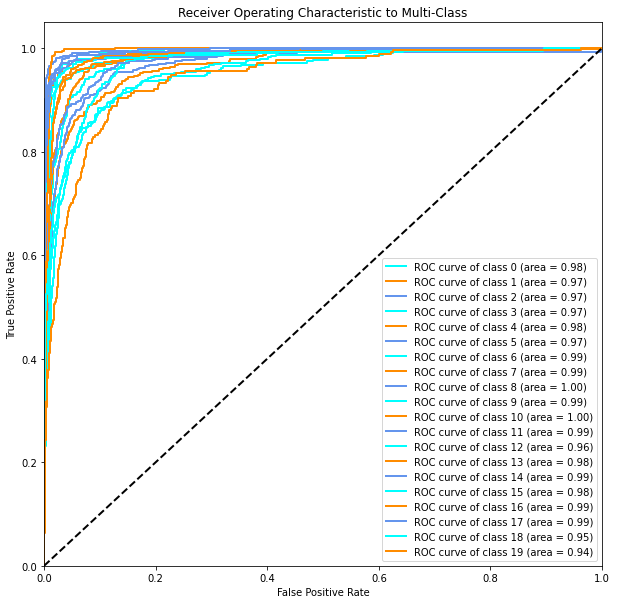

In [16]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(20):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
colors = cycle([
    'aqua', 
    'darkorange', 
    'cornflowerblue'])

for i, color in zip(range(20), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-Class')
plt.legend(loc="lower right")
plt.show()

## Classification subproblems (StackingClassifier)

In [17]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import StackingClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)

y_train = newsgroups_train.target
y_test = newsgroups_test.target


base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000)),
    ('nb', MultinomialNB())
]

clf = StackingClassifier(estimators=base_models, final_estimator=svm.LinearSVC())

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.75      0.76       319
           1       0.73      0.79      0.76       389
           2       0.81      0.77      0.79       394
           3       0.78      0.71      0.74       392
           4       0.83      0.88      0.85       385
           5       0.87      0.78      0.82       395
           6       0.83      0.87      0.85       390
           7       0.91      0.92      0.91       396
           8       0.96      0.95      0.96       398
           9       0.92      0.95      0.93       397
          10       0.94      0.97      0.95       399
          11       0.91      0.95      0.93       396
          12       0.76      0.76      0.76       393
          13       0.87      0.87      0.87       396
          14       0.88      0.92      0.90       394
          15       0.90      0.92      0.91       398
          16       0.75      0.91      0.82       364
          17       0.97    

## Clustering

In [18]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

from tqdm import tqdm

def stratified_data_sampling(data, labels, num_samples_per_class=300):
    sampled_data = []
    sampled_labels = []
    for label in tqdm(np.unique(labels)):
        indices = np.where(labels == label)[0]
        sampled_indices = np.random.choice(indices, num_samples_per_class, replace=False)
        sampled_data.extend([data[i] for i in sampled_indices])
        sampled_labels.extend([labels[i] for i in sampled_indices])
    return sampled_data, sampled_labels

newsgroups_train = fetch_20newsgroups(subset='train')

newsgroups_train.data, newsgroups_train.target = stratified_data_sampling(newsgroups_train.data, newsgroups_train.target)

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(newsgroups_train.data)

num_clusters_range = range(1, 30)

inertia = []
for num_clusters in tqdm(num_clusters_range):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)


100%|██████████| 29/29 [09:59<00:00, 20.69s/it]


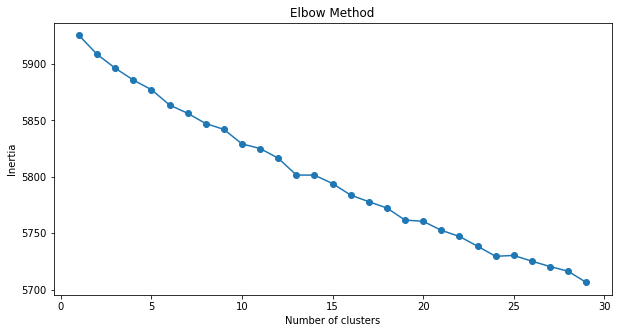

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(num_clusters_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()